# Task 3: Implementing Diabetic Retinopathy prediction

#### Dataset from Kaggle :- https://www.kaggle.com/datasets/sachinkumar413/diabetic-retinopathy-dataset?resource=download

### *Importing necessary libraries*

In [1]:
import os
import random
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import keras
from keras.layers import *
from keras.models import *
from functools import partial
from keras.preprocessing import image
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator

### *Importing all the labeled photo files from the given directory*

In [2]:
root_dir = 'diabetic_retinotherapy'
image_paths = []
labels = []

In [3]:
for folder in os.listdir(root_dir):
    folder_path = os.path.join(root_dir, folder)
    if os.path.isdir(folder_path):
        label = folder
        for filename in os.listdir(folder_path):
            if filename.lower().endswith(".jpg") or filename.lower().endswith(".jpeg") or filename.lower().endswith(".png"):
                image_path = os.path.join(folder_path, filename)
                image_paths.append(image_path)
                labels.append(label)

### *First 5 photos found*

In [4]:
np.array(image_paths)
image_paths[:5]

['diabetic_retinotherapy\\Healthy\\Healthy.png',
 'diabetic_retinotherapy\\Healthy\\Healthy_10.png',
 'diabetic_retinotherapy\\Healthy\\Healthy_100.png',
 'diabetic_retinotherapy\\Healthy\\Healthy_1000.png',
 'diabetic_retinotherapy\\Healthy\\Healthy_101.png']

In [5]:
print(len(image_paths))

2750


### *Encoding healthy, mild, moderate, proliferate and severe labels as 0 to 4 respectively*

In [6]:
labels = []
for i in image_paths:
    if "healthy" in i.lower():
        labels.append(0)
    elif "mild" in i.lower():
        labels.append(1)
    elif "moderate" in i.lower():
        labels.append(2)
    elif "proliferate" in i.lower():
        labels.append(3)
    elif "severe" in i.lower():
        labels.append(4)
print(len(labels))

2750


### *Rezising each image to the size 225 x 225 and converting them into numpy arrays*

In [7]:
imgs = []
for i in image_paths:
    image = cv2.imread(i)
    desired_shape = (225, 225)
    resized_image = cv2.resize(image, desired_shape)
    image_array = np.array(resized_image)
    image_array = image_array.astype('float32')
    image_array /= 255
    imgs.append(image_array)

In [8]:
imgs[0].shape

(225, 225, 3)

### *Creating a Neural Network model mainly comprising of the Inception V3 model with a dense layers at the end*

In [9]:
base_model = tf.keras.applications.InceptionV3(input_shape=(225,225,3),include_top=False,weights="imagenet")

for layer in base_model.layers[:-10]:
    layer.trainable=False
    
model=Sequential()
model.add(base_model)
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(5, activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 5, 5, 2048)        21802784  
                                                                 
 dropout (Dropout)           (None, 5, 5, 2048)        0         
                                                                 
 flatten (Flatten)           (None, 51200)             0         
                                                                 
 dense (Dense)               (None, 128)               6553728   
                                                                 
 dense_1 (Dense)             (None, 128)               16512     
                                                                 
 dense_2 (Dense)             (None, 5)                 645       
                                                                 
Total params: 28,373,669
Trainable params: 6,571,077
Non

In [10]:
lrd = ReduceLROnPlateau(monitor = 'accuracy',patience = 10,verbose = 1,factor = 0.50, min_lr = 1e-6)
mcp = ModelCheckpoint('model.h5')
es = EarlyStopping(verbose=1, patience=10)

In [11]:
METRICS = [
    tf.keras.metrics.CategoricalAccuracy(name='accuracy')
]

model.compile(optimizer='Adam', loss = tf.keras.losses.CategoricalCrossentropy(), metrics=METRICS)

### *Splitting the photos and their label data into training, testing data and validation data*
### *Converting each data into categorical format*

In [12]:
datagen = ImageDataGenerator(
    featurewise_center=False,
    samplewise_center=False,
    featurewise_std_normalization=False,
    samplewise_std_normalization=False,
    zca_whitening=False,
    rotation_range=20.,
    width_shift_range=0.5,
    height_shift_range=0.5,
    shear_range=30.,
    zoom_range=0.,
    channel_shift_range=0.,
    fill_mode='nearest',
    cval=0.,
    horizontal_flip=0.2,
    vertical_flip=0.2,
    rescale=None
)

X_train, X_temp, y_train, y_temp = train_test_split(imgs, labels, test_size=0.1, random_state=5)
X_validation, X_test, y_validation, y_test = train_test_split(X_temp, y_temp, test_size=0.1, random_state=5)

y_train = to_categorical(y_train, num_classes=5)
y_test = to_categorical(y_test, num_classes=5)
y_validation = to_categorical(y_validation, num_classes=5)

X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)
X_validation = np.array(X_validation)
y_validation = np.array(y_validation)
#X_train.shape, y_train.shape, X_test.shape, y_test.shape, X_validation.shape, y_validation.shape

print('Number of train: {}'.format(len(X_train)))
print('Number of validation: {}'.format(len(X_validation)))
print('Number of test: {}'.format(len(X_test)))

Number of train: 2475
Number of validation: 247
Number of test: 28


### *Training the model with the train data*

In [13]:

datagen.fit(X_train)
history = model.fit(
    X_train,
    y_train,
    validation_data=(X_validation,y_validation),
    epochs = 50,
    verbose = 1,
    callbacks=[lrd,mcp,es]
)

Epoch 1/50
78/78 [==============================] - 53s 639ms/step - loss: 2.0753 - accuracy: 0.6032 - val_loss: 1.3972 - val_accuracy: 0.5506 - lr: 0.0010
Epoch 2/50
78/78 [==============================] - 47s 603ms/step - loss: 0.7688 - accuracy: 0.7325 - val_loss: 1.5010 - val_accuracy: 0.6113 - lr: 0.0010
Epoch 3/50
78/78 [==============================] - 48s 620ms/step - loss: 0.5576 - accuracy: 0.8020 - val_loss: 1.5330 - val_accuracy: 0.5789 - lr: 0.0010
Epoch 4/50
78/78 [==============================] - 48s 622ms/step - loss: 0.4945 - accuracy: 0.8275 - val_loss: 1.0732 - val_accuracy: 0.6883 - lr: 0.0010
Epoch 5/50
78/78 [==============================] - 47s 608ms/step - loss: 0.2671 - accuracy: 0.9046 - val_loss: 1.6440 - val_accuracy: 0.5749 - lr: 0.0010
Epoch 6/50
78/78 [==============================] - 48s 612ms/step - loss: 0.2388 - accuracy: 0.9216 - val_loss: 1.5088 - val_accuracy: 0.6640 - lr: 0.0010
Epoch 7/50
78/78 [==============================] - 46s 596ms/st

### *Accuracy and loss of the above training run*

In [14]:
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')

1/1 [==============================] - 1s 504ms/step - loss: 2.6161 - accuracy: 0.4643
Loss: 2.6161155700683594
Accuracy: 0.4642857015132904


### *Testing with a "Mild" labeled image*

(225, 225, 3)

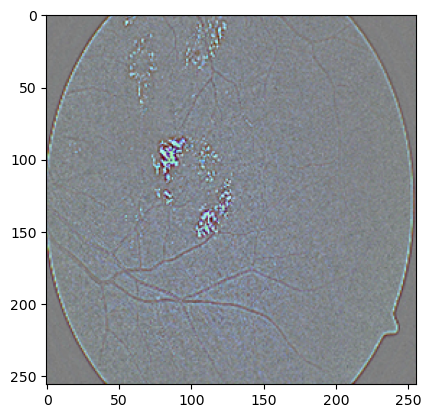

In [15]:
image = cv2.imread('diabetic_retinotherapy\\Mild\\Mild_DR_32.png')
plt.imshow(image)
resized_image = cv2.resize(image, (225, 225))
image_array = np.array(resized_image)
image_array = image_array.astype('float32')
image_array /= 255
image_array.shape

In [16]:
image_array = np.expand_dims(image_array, axis=0)
predictions = model.predict(image_array)
print(np.around(predictions, 3))

1/1 [==============================] - 1s 1s/step
[[0.    0.792 0.193 0.002 0.013]]


#### The above result is has the value closest to 1 in the second position (index 1) of the output array, which shows that the prediction is "Mild"

### *Testing with a "Proliferate" labeled image*

(225, 225, 3)

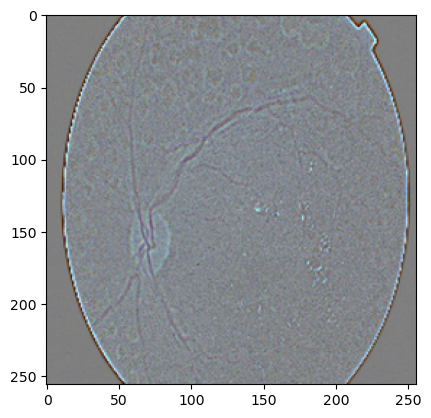

In [17]:
image = cv2.imread('diabetic_retinotherapy\\Proliferate\\Proliferate DR_212.png')
plt.imshow(image)
resized_image = cv2.resize(image, (225, 225))
image_array = np.array(resized_image)
image_array = image_array.astype('float32')
image_array /= 255
image_array.shape

In [18]:
image_array = np.expand_dims(image_array, axis=0)
predictions = model.predict(image_array)
print(np.around(predictions, 3))

1/1 [==============================] - 0s 54ms/step
[[0.    0.    0.    0.999 0.001]]


#### The above result is has the value closest to 1 in the 4th position (index 3) of the output array, which shows that the prediction is "Proliferate"

### *Testing with a "Healthy" labeled image*

(225, 225, 3)

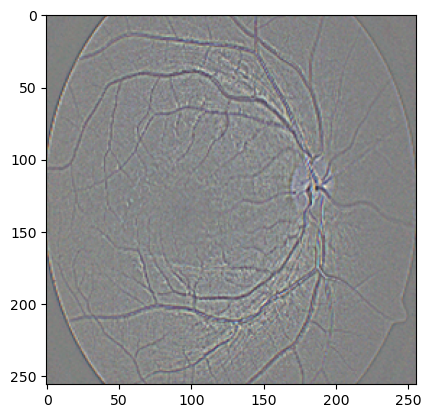

In [19]:
image = cv2.imread('diabetic_retinotherapy\\Healthy\\Healthy_17.png')
plt.imshow(image)
resized_image = cv2.resize(image, (225, 225))
image_array = np.array(resized_image)
image_array = image_array.astype('float32')
image_array /= 255
image_array.shape

In [20]:
image_array = np.expand_dims(image_array, axis=0)
predictions = model.predict(image_array)
print(np.around(predictions, 3))

1/1 [==============================] - 0s 56ms/step
[[0.718 0.    0.279 0.    0.003]]


#### The above result is has the value closest to 1 in the first position (index 0) of the output array, which shows that the prediction is "Healthy"